In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import emoji
import re
import string
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')

In [15]:
!pip install emoji -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.9 MB/s eta 0:00:00


In [2]:
df = pd.read_feather('/content/tg_channels.feather')
df.head()

,url,date,content,label
0,https://t.me/s/russianmoda/5961,2023-09-17 17:09:06+00:00,Широкие бедра всегда считались роскошью и прид...,мода
1,https://t.me/s/russianmoda/5957,2023-09-17 12:09:06+00:00,"Не знаю как у вас, но у меня ни одна осень не ...",мода
2,https://t.me/s/russianmoda/5951,2023-09-17 06:09:06+00:00,Осенью настроение немножко ухудшается. Этому с...,мода
3,https://t.me/s/russianmoda/5939,2023-09-16 17:09:06+00:00,"Кардиган очень коварен в стилизации, поэтому е...",мода
4,https://t.me/s/russianmoda/5935,2023-09-16 12:09:06+00:00,Трикотажные костюмы часто ассоциируются с брюк...,мода


In [3]:
df.isna().sum()

,0
url,0
date,0
content,48
label,0


In [29]:
len(df)

2852

In [28]:
df['label'].value_counts()

,count
label,
мода,598
технологии,589
финансы,583
крипта,583
спорт,499


In [36]:
df['label'].value_counts()

,count
label,
1,598
3,589
4,583
0,583
2,499


In [5]:
df = df[['content', 'label']]

In [4]:
df.dropna(inplace=True)

In [6]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
    "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
    "\U00002700-\U000027BF"  # Dingbats
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U00002600-\U000026FF"  # Miscellaneous Symbols
    "\U00002B50-\U00002B55"  # Miscellaneous Symbols and Pictographs
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U0001F700-\U0001F77F"  # Alchemical Symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "]+",
    flags=re.UNICODE,
)

In [9]:
def clean(text):
    text = text.lower()  # нижний регистр
    text = re.sub(r"http\S+", " ", text)  # удаляем ссылки
    text = re.sub(r"@\w+", " ", text)  # удаляем упоминания пользователей
    text = re.sub(r"#\w+", " ", text)  # удаляем хэштеги
    text = re.sub(r"\d+", " ", text)  # удаляем числа
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"<.*?>", " ", text)  #
    text = re.sub(r"[️«»—]", " ", text)
    text = re.sub(r"[^а-яё ]", " ", text)
    text = text.lower()
    text = emoji_pattern.sub(r"", text)
    return text

In [10]:
clean_text = [clean(text) for text in df["content"]]

In [11]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
df['cleaned_content'] = clean_text

In [13]:
encoded_content = df['cleaned_content'].apply(
    lambda x: tokenizer(x, max_length=64, truncation=True, padding='max_length')
).values

In [14]:
print(f"Source text: {df['cleaned_content'][10]}")
print(f'Encoded text: {encoded_content[10]}')

Source text: сегодня сходила на милейшее мероприятие   завтрак посвященный запуску новой коллекции            нет ничего приятнее времени проведенного в кругу стильных единомышленников  коллекцию представили очень креативно и профессионально получила большое удовольствие от мероприятия здорово когда бренды устраивают настолько продуманные презентацииотдельное спасибо марине за приглашение    у нее мегаклассный тгканал о котором я даже не знала  всё о мире моды звездах и отношениях подписалась не раздумывая
Encoded text: {'input_ids': [101, 12904, 16320, 3297, 1469, 14482, 107551, 34710, 84669, 39063, 75116, 11317, 21601, 8953, 14179, 25567, 5148, 6651, 38916, 845, 38289, 19981, 1755, 70737, 29689, 38296, 7805, 33446, 69848, 851, 44982, 10395, 13842, 56474, 1641, 19334, 94737, 5318, 78368, 54080, 20308, 97347, 2059, 43038, 57773, 896, 2784, 107685, 97733, 842, 1758, 31234, 875, 20032, 64507, 58736, 6639, 1916, 867, 848, 63157, 864, 612, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0

In [15]:
class BertInputs(torch.utils.data.Dataset):
    def __init__(self, encoded_content):
        super().__init__()
        self.inputs = encoded_content

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        # print(self.inputs[idx])
        return (torch.Tensor(self.inputs[idx]['input_ids']).cuda().long(),
                torch.Tensor(self.inputs[idx]['attention_mask']).cuda().long())

dataset = BertInputs(encoded_content)

In [16]:
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
batch = next(iter(loader))
batch[0].size()

torch.Size([128, 64])

In [17]:
model.cuda()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [18]:
%%time
features = []
for inputs, masks in loader:
    with torch.inference_mode():
        model_out = model(inputs, attention_mask=masks)
        vectors = model_out.last_hidden_state[:, 0, :]
    features.extend(vectors.cpu().numpy())
len(features)

CPU times: user 7.68 s, sys: 104 ms, total: 7.78 s
Wall time: 9.39 s


2852

In [60]:
len(features[0])

768

In [68]:
X_train, y_train = features, df['label']
print(f'Features shape: {len(X_train)}, Target shape: {len(y_train)}')

Features shape: 2852, Target shape: 2852


In [56]:
df['label'].value_counts()/len(features)*100

,count
label,
1,20.967742
3,20.652174
4,20.441795
0,20.441795
2,17.496494


In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [57]:
model_svc = svm.SVC()

In [58]:
model_svc.fit(X_train, y_train)
prdes_svc = model_svc.predict(X_val)

In [59]:
print(f'Accuracy SVC: {accuracy_score(y_val, prdes_svc)}, F_1_SVC: {f1_score(y_val, prdes_svc, average="weighted")}')

Accuracy SVC: 0.8774080560420315, F_1_SVC: 0.8780920527511705


In [69]:
model_log_reg = LogisticRegression()
model_log_reg.fit(X_train, y_train)
#prdes_log_reg = model_log_reg.predict(X_val)

LogisticRegression()

In [61]:
print(f'Accuracy Log_Reg: {accuracy_score(y_val, prdes_log_reg)}, Log_Reg_F_1: {f1_score(y_val, prdes_log_reg, average="weighted")}')

Accuracy Log_Reg: 0.8931698774080561, Log_Reg_F_1: 0.892963902453314


In [62]:
model_forest = RandomForestClassifier()
model_forest.fit(X_train, y_train)
preds_forest = model_forest.predict(X_val)

In [63]:
print(f'Accuracy RF: {accuracy_score(y_val, preds_forest)}, RF_F1: {f1_score(y_val, preds_forest, average="weighted")}')

Accuracy RF: 0.8371278458844134, RF_F1: 0.8385435521273475


In [64]:
def predict_class(text,model_to_embed, model_to_predict):
  text = clean(text)
  class_list = ['Крипта', 'Мода', 'Спорт', 'Технологии', 'Финансы']
  encoded_input = tokenizer(text, max_length=64, truncation=True, padding='max_length', return_tensors='pt')
  encoded_input = {k: v.to(model_to_embed.device) for k, v in encoded_input.items()}

  with torch.no_grad():
      model_output = model_to_embed(**encoded_input)

  embeddings = model_output.last_hidden_state[:, 0, :]

  embeddings = torch.nn.functional.normalize(embeddings)

  embeddings_np = embeddings.cpu().numpy()

  pred_class = model_to_predict.predict(embeddings_np)

  pred_proba = model_to_predict.predict_proba(embeddings_np)
  confidence = np.max(pred_proba)

  return f'Predicted class: {class_list[pred_class[0]]}, Confidence: {confidence:.4f}'

In [71]:
predict_class('Сегодня я пошел на рынок и купил гавайскую рубашку, чтобы поехать со своими друзьями акционерами на яхту пить пиво и вкладываться в крипту', model, model_log_reg)

'Predicted class: Мода, Confidence: 0.2888'

In [107]:
type(features)

list

In [19]:
flattened_list = [arr.flatten() for arr in features]

# Create a pandas DataFrame from the list of flattened arrays
df_to_umap = pd.DataFrame(flattened_list)

In [20]:
df_to_umap.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.085085,0.025430,0.098354,-0.078891,-0.006745,0.061092,-0.135366,0.030448,-0.097335,0.231273,...,-0.115996,0.015343,-0.449897,-0.069264,-0.008546,-0.143717,-0.011393,0.133305,-0.089165,-0.191854
1,0.108698,-0.144819,0.170653,-0.558899,-0.159866,-0.439706,0.060471,0.250329,-0.627317,-0.101333,...,0.214020,0.088779,-0.398198,0.051503,-0.019718,-0.162998,0.110092,0.382179,-0.393726,-0.272393
2,-0.017325,-0.367487,-0.063676,-0.193454,-0.175022,-0.430374,0.028381,0.189295,-0.416062,0.031598,...,0.400842,0.025824,0.049097,0.164762,-0.093093,-0.162183,-0.134903,0.203394,0.067071,-0.192409
3,0.287661,-0.085793,-0.063469,-0.363008,-0.492836,-0.210368,0.133773,0.125266,-0.107076,0.176104,...,0.085913,0.229155,-0.095464,-0.464667,-0.204516,0.066219,0.141122,0.203945,-0.000915,0.080212
4,0.143312,-0.097873,0.222401,-0.300473,0.091195,-0.084350,0.088851,0.142464,-0.230919,0.630637,...,0.209234,0.219277,-0.070692,-0.318202,-0.135811,-0.123174,0.148975,0.491447,-0.285293,-0.547223


In [21]:
len(df_to_umap)

2852

In [22]:
!pip install umap-learn

In [23]:
from umap import UMAP

In [75]:
umap = UMAP(n_components=2)
X_umap = pd.DataFrame(umap.fit_transform(df_to_umap), columns = list(range(0,2)))

In [77]:
X_umap['label'] = df['label']

In [78]:
X_umap

,0,1,label
0,0.826220,-0.183713,1.0
1,-1.686356,3.456978,1.0
2,-0.588597,2.302161,1.0
3,-1.415889,1.694207,1.0
4,0.320957,0.672169,1.0
...,...,...,...
2847,2.732851,3.336411,0.0
2848,3.407303,2.953197,0.0
2849,3.701493,4.308497,0.0
2850,1.236603,2.469821,0.0


In [80]:
X_umap.columns

Index([0, 1, 'label'], dtype='object')

In [79]:
import seaborn as sns

In [82]:
df = pd.read_feather('/content/tg_channels.feather')

In [83]:
df.dropna(inplace=True)

In [84]:
X_umap['label2'] = df['label']

<Axes: xlabel='0', ylabel='1'>

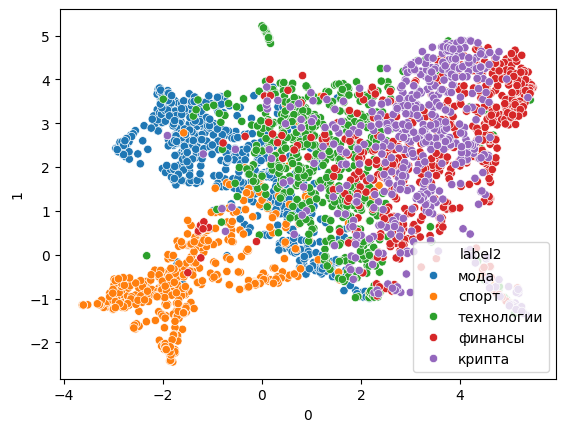

In [85]:
sns.scatterplot(data=X_umap, x=0, y=1, hue = 'label2')

In [72]:
import joblib


In [73]:
joblib.dump(model_log_reg, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']